In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from gensim.models.callbacks import CallbackAny2Vec

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
book_filenames = sorted(glob.glob('../data/GoT_novels/*.txt'))

In [8]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '../data/GoT_novels/got1.txt'...
Corpus is now 1770659 characters long

Reading '../data/GoT_novels/got2.txt'...
Corpus is now 4071041 characters long

Reading '../data/GoT_novels/got3.txt'...
Corpus is now 6391405 characters long

Reading '../data/GoT_novels/got4.txt'...
Corpus is now 8107945 characters long

Reading '../data/GoT_novels/got5.txt'...
Corpus is now 9719485 characters long



In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)


In [11]:
print(type(raw_sentences))

<class 'list'>


In [12]:
print(raw_sentences[5])

Heraldic crest by Virginia Norey.


In [13]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [14]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [15]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [16]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


In [17]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1


class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, model):
        print("Epoch #{} . Loss-Value: {}".format(self.epoch, thrones2vec.get_latest_training_loss()))
        self.epoch += 1
        
        
epoch_logger = EpochLogger()

In [18]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [19]:
thrones2vec.build_vocab(sentences)


2019-01-13 20:48:40,130 : INFO : collecting all words and their counts
2019-01-13 20:48:40,131 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-13 20:48:40,153 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2019-01-13 20:48:40,174 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2019-01-13 20:48:40,197 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2019-01-13 20:48:40,218 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2019-01-13 20:48:40,237 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2019-01-13 20:48:40,260 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2019-01-13 20:48:40,285 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2019-01-13 20:48:40,307 : INFO : PROGRESS: at 

In [20]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))


Word2Vec vocabulary length: 17277


In [21]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=3, compute_loss=True, callbacks=[epoch_logger])

2019-01-13 20:48:40,781 : INFO : training model with 8 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-01-13 20:48:41,803 : INFO : EPOCH 1 - PROGRESS: at 38.31% examples, 518205 words/s, in_qsize 15, out_qsize 0
2019-01-13 20:48:42,811 : INFO : EPOCH 1 - PROGRESS: at 79.63% examples, 546013 words/s, in_qsize 15, out_qsize 0
2019-01-13 20:48:43,261 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-13 20:48:43,262 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-13 20:48:43,271 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-13 20:48:43,284 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-13 20:48:43,287 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-13 20:48:43,295 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-13 20:48:43,297 : INFO : worker thread finished; awaiting finish of 

Epoch #0 . Loss-Value: 2707862.5


2019-01-13 20:48:44,319 : INFO : EPOCH 2 - PROGRESS: at 37.75% examples, 516073 words/s, in_qsize 14, out_qsize 1
2019-01-13 20:48:45,325 : INFO : EPOCH 2 - PROGRESS: at 80.23% examples, 553394 words/s, in_qsize 14, out_qsize 1
2019-01-13 20:48:45,730 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-13 20:48:45,738 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-13 20:48:45,740 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-13 20:48:45,745 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-13 20:48:45,756 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-13 20:48:45,772 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-13 20:48:45,776 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-13 20:48:45,783 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-13 20:48:45,783 : INFO : EPOCH - 2 :

Epoch #1 . Loss-Value: 5116563.5


2019-01-13 20:48:46,816 : INFO : EPOCH 3 - PROGRESS: at 41.45% examples, 551781 words/s, in_qsize 15, out_qsize 0
2019-01-13 20:48:47,837 : INFO : EPOCH 3 - PROGRESS: at 84.49% examples, 570866 words/s, in_qsize 15, out_qsize 0
2019-01-13 20:48:48,157 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-13 20:48:48,168 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-13 20:48:48,172 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-13 20:48:48,180 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-13 20:48:48,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-13 20:48:48,187 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-13 20:48:48,208 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-13 20:48:48,217 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-13 20:48:48,217 : INFO : EPOCH - 3 :

Epoch #2 . Loss-Value: 7363355.0


(4212919, 5454309)

In [22]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [23]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))



2019-01-13 20:48:48,228 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-01-13 20:48:48,229 : INFO : not storing attribute vectors_norm
2019-01-13 20:48:48,230 : INFO : not storing attribute cum_table
2019-01-13 20:48:48,636 : INFO : saved trained/thrones2vec.w2v


In [24]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))



2019-01-13 20:48:48,640 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2019-01-13 20:48:48,886 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2019-01-13 20:48:48,887 : INFO : setting ignored attribute vectors_norm to None
2019-01-13 20:48:48,888 : INFO : loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2019-01-13 20:48:48,888 : INFO : loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2019-01-13 20:48:48,889 : INFO : setting ignored attribute cum_table to None
2019-01-13 20:48:48,889 : INFO : loaded trained/thrones2vec.w2v


In [25]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)



In [26]:
all_word_vectors_matrix = thrones2vec.wv.syn0



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [27]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)



In [28]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

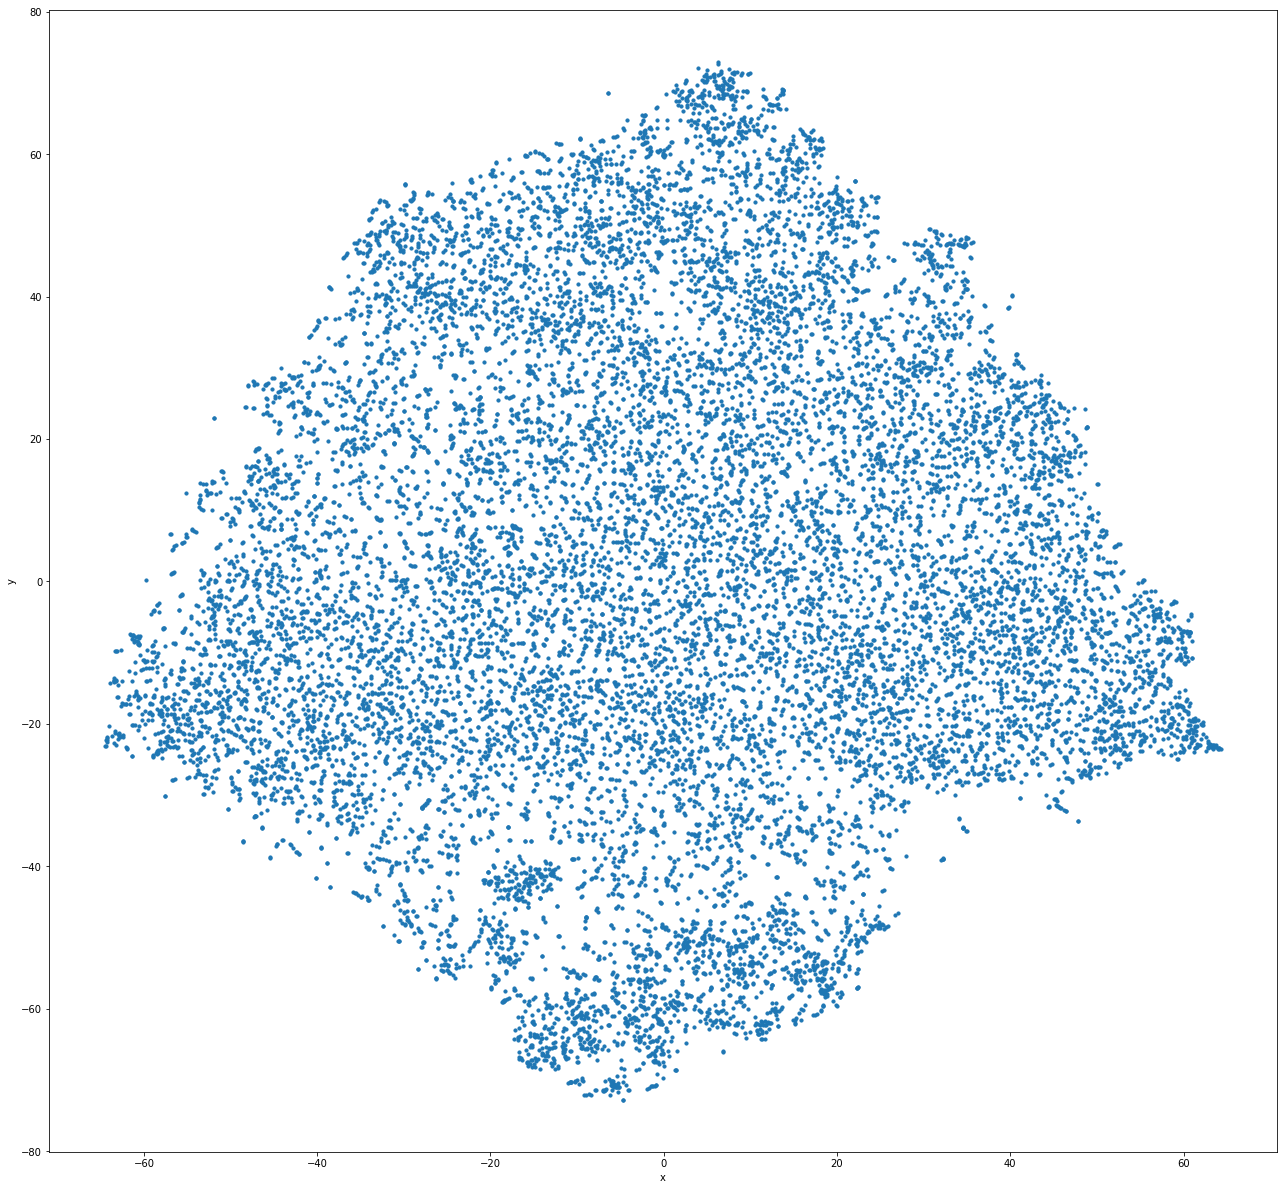

In [29]:
points.plot.scatter("x", "y", s=10, figsize=(22, 21))



In [30]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

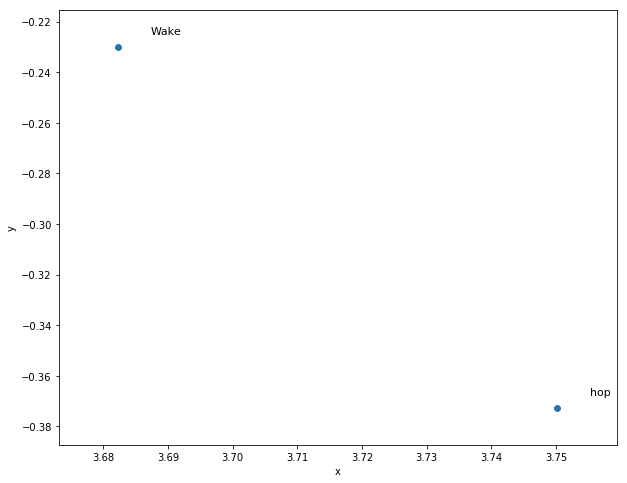

In [31]:
plot_region(x_bounds=(3.0, 4.2), y_bounds=(-0.5, -0.1))


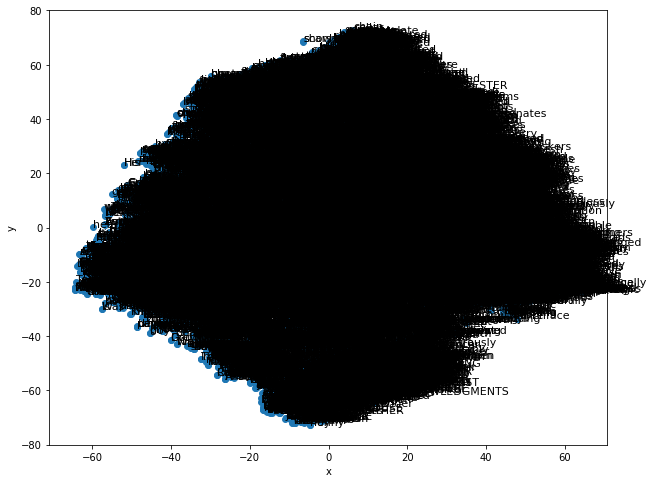

In [32]:
plot_region(x_bounds=(-100.0, 100.2), y_bounds=(-100.5, 100.1))



In [33]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [34]:
nearest_similarity_cosmul("Jaime", "Cersei", "Catelyn")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.
2019-01-13 20:58:46,280 : INFO : precomputing L2-norms of word weight vectors


Jaime is related to Cersei, as Brienne is related to Catelyn


'Brienne'